This notebook is for the Figure 7 analysis related to the imbalanced/rebalanced clustering metrics (ARI, AMI, Homogeneity, Completeness, and V-measure) and their use cases with toy simulated data and real single-cell RNA sequencing datasets.

In [1]:
import os 
import sys
sys.path.append("../../src/python/")
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import scanpy as sc
import anndata as ann
import scvi 
import bbknn 
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score, \
    homogeneity_score, completeness_score, v_measure_score
from sklearn.cluster import KMeans

from imbalanced_clustering import * 

Global seed set to 0


In [2]:
# Change to top level dir
os.chdir("../../..")

### Case demonstration #1 - 3 classes 2 clusters imbalanced 

This first use-case utilizes simulated data to show the differences between the baseline and balanced clustering metrics in a scenario with 3 classes of differing size, and an inaccurate clustering result that utilizes k = 2 in kmeans. 

The results will be saved to tsv files to be plotted in R. 

In [8]:
# Define a function that returns values for imbalanced and balanced ARI, AMI, Homogeneity, 
# Completeness, and V-measure - for comparison downstream
def return_metrics(class_arr, cluster_arr):
    # Determine the imbalanced (base) metric scores 
    ari_imbalanced = adjusted_rand_score(class_arr, cluster_arr)
    ami_imbalanced = adjusted_mutual_info_score(class_arr, cluster_arr)
    homog_imbalanced = homogeneity_score(class_arr, cluster_arr)
    complete_imbalanced = completeness_score(class_arr, cluster_arr)
    v_measure_imbalanced = v_measure_score(class_arr, cluster_arr)

    # Determine the balanced metrics from `imbalanced-clustering`
    ari_balanced = balanced_adjusted_rand_index(class_arr, cluster_arr)
    ami_balanced = balanced_adjusted_mutual_info(class_arr, cluster_arr)
    homog_balanced = balanced_homogeneity(class_arr, cluster_arr)
    complete_balanced = balanced_completeness(class_arr, cluster_arr)
    v_measure_balanced = balanced_v_measure(class_arr, cluster_arr)
    
    # Return paired balanced imbalance scores
    return (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced)

# Define a function that takes the return of 'return_metrics' and collapses the result
# into a dataframe for saving
def return_metrics_to_df(output, trial_name):
    # Unpack the output into the appropriate values 
    (ari_imbalanced, ari_balanced), (ami_imbalanced, ami_balanced), \
        (homog_imbalanced, homog_balanced), (complete_imbalanced, complete_balanced), \
        (v_measure_imbalanced, v_measure_balanced) = output 
    
    # Create a dataframe of the results 
    metrics = [
        "ARI imbalanced",
        "AMI imbalanced",
        "Homogeneity imbalanced",
        "Completeness imbalanced",
        "V-measure imbalanced",
        "ARI balanced",
        "AMI balanced",
        "Homogeneity balanced",
        "Completeness balanced",
        "V-measure balanced"
    ]
    metrics_results = [
        ari_imbalanced,
        ami_imbalanced,
        homog_imbalanced,
        complete_imbalanced,
        v_measure_imbalanced,
        ari_balanced,
        ami_balanced,
        homog_balanced,
        complete_balanced,
        v_measure_balanced
    ]
    metrics_type = [
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "imbalanced",
        "balanced",
        "balanced",
        "balanced",
        "balanced",
        "balanced"
    ]
    metrics_df = pd.DataFrame({
        "Metric": metrics,
        "Value": metrics_results,
        "Type": metrics_type
    })
    metrics_df["Trial"] = trial_name
    
    # Return dataframe of results
    return metrics_df


Class scatterplot:


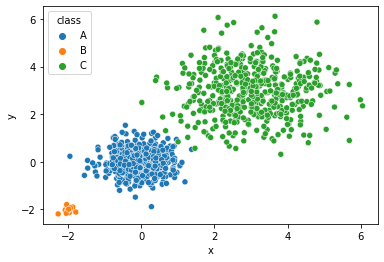

K-means classification scatterplot:


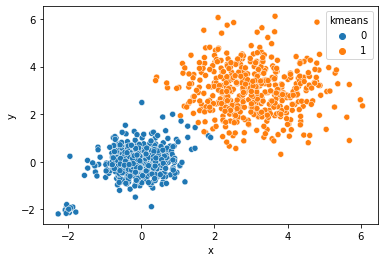

ARI imbalanced: 0.915 ARI balanced: 0.5434
AMI imbalanced: 0.8671 AMI balanced: 0.686
Homogeneity imbalanced: 0.8204 Homogeneity balanced: 0.5402
Completeness imbalanced: 0.9198 Completeness balanced : 0.941
V-measure imbalanced: 0.8673 V-measure balanced: 0.6864


<Figure size 432x288 with 0 Axes>

In [9]:
# Sample three classes from separated gaussian distributions with varying
# standard deviations and class size 
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (500, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = -2, scale = 0.1, size = (20, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = 3, scale = 1, size = (500, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 2, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Create output dir to save these results
if os.path.isdir("outs/balanced_metrics/results"):
    pass
else:
    os.makedirs("outs/balanced_metrics/results")

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7A_3_class_2_cluster_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7A_cluster_class_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7A_3_class_2_cluster_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7A_metrics_results.tsv",
    sep = "\t",
    index = False
)

### Case demonstration #2 - 3 classes 3 clusters imbalanced 

This second use-case utilizes simulated data to show the differences between the baseline and balanced clustering metrics in a scenario with 3 classes of differing size, and an accurate cluster number (k = 3 in kmeans), but highly overlapping results. This result indicates how the balanced metrics treat the good results for the smaller classes equally as important as the poor result on the larger class in the middle.

The results will be saved to tsv files to be plotted in R. 

Class scatterplot:


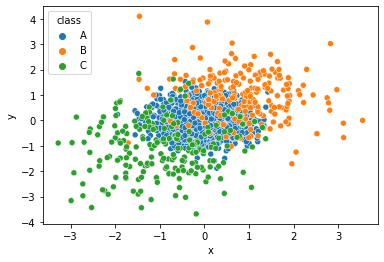

K-means classification scatterplot:


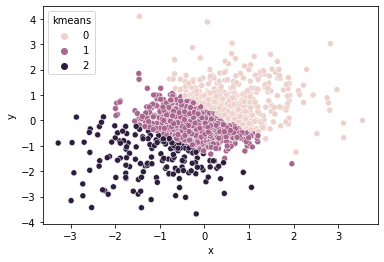

ARI imbalanced: 0.3551 ARI balanced: 0.436
AMI imbalanced: 0.3125 AMI balanced: 0.4328
Homogeneity imbalanced: 0.3557 Homogeneity balanced: 0.4278
Completeness imbalanced: 0.2802 Completeness balanced : 0.4391
V-measure imbalanced: 0.3135 V-measure balanced: 0.4334


<Figure size 432x288 with 0 Axes>

In [10]:
# Sample three classes, not that well separated, from gaussian distributions with 
# varying standard deviations and class size, such that the larger class is in 
# the middle and smaller classes on the edges  
c_1 = np.random.default_rng(seed = 0).normal(loc = 0, scale = 0.5, size = (1500, 2))
c_2 = np.random.default_rng(seed = 1).normal(loc = 1, scale = 1, size = (200, 2))
c_3 = np.random.default_rng(seed = 2).normal(loc = -1, scale = 1, size = (200, 2))

# Plot the given results for each class using seaborn
# Ensure to clear plot afterwards 
cluster_df = pd.DataFrame({
    "x" : np.concatenate((c_1[:, 0], c_2[:, 0], c_3[:, 0])),
    "y" : np.concatenate((c_1[:, 1], c_2[:, 1], c_3[:, 1])),
    "class": np.concatenate(
        (
            np.repeat("A", len(c_1)),
            np.repeat("B", len(c_2)),
            np.repeat("C", len(c_3))
        )
    )
})
print("Class scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "class",
    data = cluster_df
)
plt.show()
plt.clf()

# Perform k-means clustering with k = 2, and plot the results  
cluster_arr = np.array(cluster_df.iloc[:, 0:2])
kmeans_res = KMeans(n_clusters = 3, random_state = 42).fit_predict(X = cluster_arr)

cluster_df["kmeans"] = kmeans_res # Add k-means to cluster df 
print("K-means classification scatterplot:")
sns.scatterplot(
    x = "x",
    y = "y",
    hue = "kmeans",
    data = cluster_df
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7B_3_class_3_cluster_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7B_cluster_class_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["class"], cluster_arr = cluster_df["kmeans"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7A_3_class_3_cluster_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7B_metrics_results.tsv",
    sep = "\t",
    index = False
)

### Case demonstration #3 - Single-cell dataset and Leiden clustering result with many smaller celltypes present 
 
This third use case examines a dataset of pancreatic islet cells with single-cell data from Celseq2. 

Here, quite a few celltypes are imbalanced, meaning that they are present in smaller number. The regular single-cell analysis workflow will be carried out and the cells will be clustered using Leiden clustering. From there, the imbalanced and balanced metrics for Leiden clustering will be compared, especially with respect to the clustering results for the smaller celltypes. The UMAP plot of these results will be examined.  

The results will be saved to tsv files to be plotted in R. 

Celltype scatterplot:


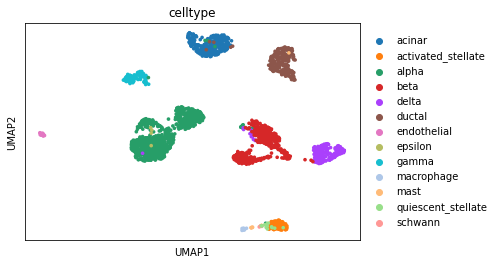

Leiden clustering scatterplot:


<Figure size 432x288 with 0 Axes>

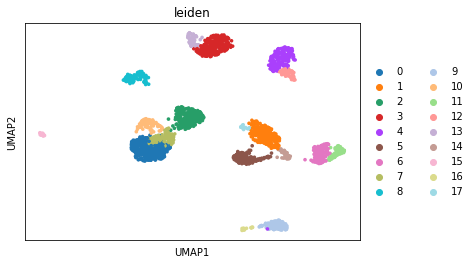

ARI imbalanced: 0.4931 ARI balanced: 0.5898
AMI imbalanced: 0.7636 AMI balanced: 0.8159
Homogeneity imbalanced: 0.938 Homogeneity balanced: 0.8095
Completeness imbalanced: 0.6503 Completeness balanced : 0.8293
V-measure imbalanced: 0.7681 V-measure balanced: 0.8193


<Figure size 432x288 with 0 Axes>

In [12]:
# Load the pancreatic dataset as a scanpy object
panc_adata = sc.read_h5ad("resources/h5ad_files/int_datasets/panc_4_batch/pancreas_filtered_only_celseq2.h5ad")

# Perform the typical single-cell analysis workflow, ending with Leiden clustering and UMAP embedding of the data
sc.pp.normalize_total(
    panc_adata,
    target_sum = 1e4
)
sc.pp.log1p(panc_adata)
sc.pp.highly_variable_genes(
    panc_adata,
    n_top_genes = 2500,
    flavor = "seurat"
)
sc.pp.pca(panc_adata, svd_solver="arpack")
sc.pp.neighbors(
    panc_adata,
    n_neighbors = 15,
    n_pcs = 20
)
sc.tl.leiden(panc_adata)
sc.tl.umap(panc_adata)

# Create a dataframe of the UMAP results with respect to the coordinates, celltypes, and leiden clustering results
umap_1 = panc_adata.obsm["X_umap"][:, 0]
umap_2 = panc_adata.obsm["X_umap"][:, 1]
celltypes = panc_adata.obs["celltype"].__array__()
clusters = panc_adata.obs["leiden"].__array__()
cluster_df = pd.DataFrame({
    "x" : umap_1,
    "y" : umap_2,
    "celltype": celltypes,
    "cluster": clusters
})

# Plot the celltype data
print("Celltype scatterplot:")
sc.pl.umap(
    panc_adata,
    color = "celltype"
)
plt.show()
plt.clf()

# Plot the cluster results data
print("Leiden clustering scatterplot:")
sc.pl.umap(
    panc_adata,
    color = "leiden",
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7C_panc_data_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7C_cluster_celltype_imbal_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7C_cluster_celltype_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7C_metrics_results.tsv",
    sep = "\t",
    index = False
)

This previous case examines where smaller celltypes are clustered well and should have greater influence on the scores.

### Case demonstration #4 - Single-cell dataset and Leiden clustering result balanced data and only one smaller celltype (that has high relatedness to another celltype)


The next case highlights the opposite, where a smaller celltype (CD4 T cells) are not clustered well, but have a greater influence on the scores in the balanced metrics compared to the imbalanced metrics. 

Here one batch of the balanced PBMC data is used, and CD4 T cells are downsampled to 0.1 proportion (much like the control experiments). **Note that the resolution parameter here is changed for Leiden clustering to approximate the case that this class might get "hidden" if we took the entire T-cell cluster as one cluster. This is a realistic resolution as it perfectly clusters all of the other celltypes**.

/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Celltype scatterplot:


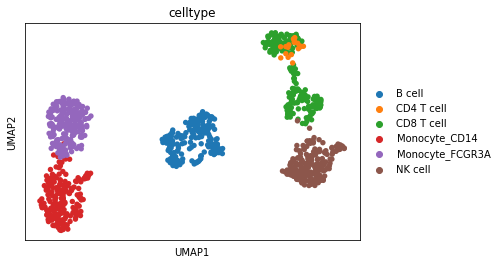

Leiden clustering scatterplot:


<Figure size 432x288 with 0 Axes>

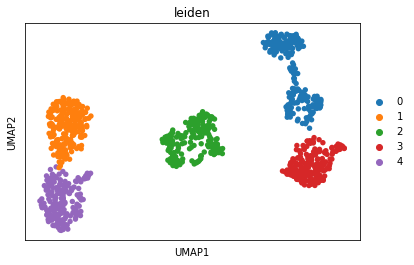

ARI imbalanced: 0.9466 ARI balanced: 0.8032
AMI imbalanced: 0.9491 AMI balanced: 0.9076
Homogeneity imbalanced: 0.9305 Homogeneity balanced: 0.8492
Completeness imbalanced: 0.969 Completeness balanced : 0.9758
V-measure imbalanced: 0.9494 V-measure balanced: 0.9081


<Figure size 432x288 with 0 Axes>

In [13]:
# Load the balanced PBMC data dataset as a scanpy object
pbmc_adata = sc.read_h5ad("resources/h5ad_files/int_datasets/pbmc_2_batch_base_balanced/tran_exp5_pbmc_batch1_balanced.h5ad")

# Downsample selected celltypes by given proportion
celltypes_sample = ["CD4 T cell"]
proportion = 0.1
for celltype in celltypes_sample:
    adata_celltype = pbmc_adata[pbmc_adata.obs["celltype"] == celltype]
    adata_noncelltype = pbmc_adata[pbmc_adata.obs["celltype"] != celltype]
    adata_celltype_ds = sc.pp.subsample(
        adata_celltype, 
        fraction = proportion,
        random_state = None,
        copy = True
    )
    pbmc_adata = ann.AnnData.concatenate(adata_noncelltype, adata_celltype_ds)

# Perform the typical single-cell analysis workflow, ending with Leiden clustering and UMAP embedding of the data
sc.pp.normalize_total(
    pbmc_adata,
    target_sum = 1e4
)
sc.pp.log1p(pbmc_adata)
sc.pp.highly_variable_genes(
    pbmc_adata,
    n_top_genes = 2500,
    flavor = "seurat"
)
sc.pp.pca(pbmc_adata, svd_solver="arpack")
sc.pp.neighbors(
    pbmc_adata,
    n_neighbors = 15,
    n_pcs = 20
)
sc.tl.leiden(pbmc_adata, resolution = 0.1)
sc.tl.umap(pbmc_adata)

# Create a dataframe of the UMAP results with respect to the coordinates, celltypes, and leiden clustering results
umap_1 = pbmc_adata.obsm["X_umap"][:, 0]
umap_2 = pbmc_adata.obsm["X_umap"][:, 1]
celltypes = pbmc_adata.obs["celltype"].__array__()
clusters = pbmc_adata.obs["leiden"].__array__()
batches = pbmc_adata.obs["batch"].__array__()
cluster_df = pd.DataFrame({
    "x" : umap_1,
    "y" : umap_2,
    "celltype": celltypes,
    "cluster": clusters,
    "batch": batches
})

# Plot the celltype data
print("Celltype scatterplot:")
sc.pl.umap(
    pbmc_adata,
    color = "celltype"
)
plt.show()
plt.clf()

# Plot the cluster results data
print("Leiden clustering scatterplot:")
sc.pl.umap(
    pbmc_adata,
    color = "leiden",
)
plt.show()
plt.clf()

# Return and print balanced and imbalanced comparisons 
aris, amis, homogs, completes, v_measures = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
print(
    "ARI imbalanced: " + str(round(aris[0], 4)) + " " + 
    "ARI balanced: " + str(round(aris[1], 4))
)
print(
    "AMI imbalanced: " + str(round(amis[0], 4)) + " " +
    "AMI balanced: " + str(round(amis[1], 4))
)
print(
    "Homogeneity imbalanced: " + str(round(homogs[0], 4)) + " " +
    "Homogeneity balanced: " + str(round(homogs[1], 4))
)
print(
    "Completeness imbalanced: " + str(round(completes[0], 4)) + " " +
    "Completeness balanced : " + str(round(completes[1], 4))
)
print(
    "V-measure imbalanced: " + str(round(v_measures[0], 4)) + " " +
    "V-measure balanced: " + str(round(v_measures[1], 4))
)

# Save cluster dataframe and metrics dataframe results to disk 
cluster_df["Trial"] = "7D_pbmc_data_imbal"
cluster_df.to_csv(
    "outs/balanced_metrics/results/04_7D_cluster_celltype_imbal_results.tsv",
    sep = "\t",
    index = False
)

return_metrics_full_out = return_metrics(
    class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
)
metrics_df = return_metrics_to_df(
    return_metrics_full_out,
    "7D_cluster_celltype_imbal"
)
metrics_df.to_csv(
    "outs/balanced_metrics/results/04_7D_metrics_results.tsv",
    sep = "\t",
    index = False
)

### Case demonstration #5 - Single-cell dataset and Leiden clustering result on imbalanced data and two smaller celltypes, after integration

The last case will explore a specific test case in integration - particularly of two batches of balanced PBMC data where CD4 T cells and FCGR3A monocytes are downsampled from one batch. 

In [14]:
# Load the balanced PBMC data dataset as a scanpy object
pbmc_adata_1 = sc.read_h5ad("resources/h5ad_files/int_datasets/pbmc_2_batch_base_balanced/tran_exp5_pbmc_batch1_balanced.h5ad")
pbmc_adata_2 = sc.read_h5ad("resources/h5ad_files/int_datasets/pbmc_2_batch_base_balanced/tran_exp5_pbmc_batch2_balanced.h5ad")

# Downsample botch batches for both CD4 T cells and FCGR3A Monocytes to 0.1 proportion
celltypes_sample = ["CD4 T cell", "Monocyte_FCGR3A"]
proportion = 0.1
for celltype in celltypes_sample:
    adata_celltype = pbmc_adata_1[pbmc_adata_1.obs["celltype"] == celltype]
    adata_noncelltype = pbmc_adata_1[pbmc_adata_1.obs["celltype"] != celltype]
    adata_celltype_ds = sc.pp.subsample(
        adata_celltype, 
        fraction = proportion,
        random_state = None,
        copy = True
    )
    pbmc_adata_1 = ann.AnnData.concatenate(adata_noncelltype, adata_celltype_ds)
    
for celltype in celltypes_sample:
    adata_celltype = pbmc_adata_2[pbmc_adata_2.obs["celltype"] == celltype]
    adata_noncelltype = pbmc_adata_2[pbmc_adata_2.obs["celltype"] != celltype]
    adata_celltype_ds = sc.pp.subsample(
        adata_celltype, 
        fraction = proportion,
        random_state = None,
        copy = True
    )
    pbmc_adata_2 = ann.AnnData.concatenate(adata_noncelltype, adata_celltype_ds)
    
# Define function to perform typical single-cell workflow to get embeddings (no integration)
def unintegrated(adata, n_neighbors = 15, n_pcs = 20, num_hvgs = 2500):
    print("Performing unintegrated.." + "\n")
    aunint = adata.copy()
    sc.pp.normalize_total(
        aunint,
        target_sum = 1e4
    )
    sc.pp.log1p(aunint)
    sc.pp.highly_variable_genes(
        aunint,
        n_top_genes = num_hvgs,
        flavor = "seurat"
    )
    sc.pp.pca(aunint, svd_solver="arpack")
    sc.pp.neighbors(
        aunint,
        n_neighbors = n_neighbors,
        n_pcs = n_pcs,
    )
    sc.tl.leiden(aunint)
    sc.tl.umap(aunint)
    print("Done!" + "\n")
    return aunint
    
# Define functions to integrate the data using scvi, harmony, bbknn, and scanorama 
def scvi_integrate(adata, n_neighbors = 15, n_pcs = 20):
    print("Performing scVI integration.." + "\n")
    ascvi = adata.copy()
    scvi.data.setup_anndata(ascvi, batch_key = "batch")
    vae = scvi.model.SCVI(ascvi)
    vae.train(use_gpu = True)
    ascvi.obsm["X_scVI"] = vae.get_latent_representation()
    ascvi.obsm["X_kmeans"] = ascvi.obsm["X_scVI"][:, 0:n_pcs]
    sc.pp.neighbors(
        ascvi,
        n_neighbors = n_neighbors,
        n_pcs = n_pcs,
        use_rep = "X_scVI"
    )
    sc.tl.leiden(ascvi)
    sc.tl.umap(ascvi)
    print("Done!" + "\n")
    return ascvi

def harmony_integrate(adata, n_neighbors = 15, n_pcs = 20, num_hvgs = 2500):
    print("Performing Harmony integration.." + "\n")
    aharmony = adata.copy()
    sc.pp.normalize_total(
        aharmony,
        target_sum = 1e4
    )
    sc.pp.log1p(aharmony)
    sc.pp.highly_variable_genes(
        aharmony,
        n_top_genes = num_hvgs,
        flavor = "seurat"
    )
    sc.pp.pca(aharmony, svd_solver="arpack")
    sc.external.pp.harmony_integrate(
        aharmony,
        key = "batch",
        random_state = None
    )
    sc.pp.neighbors(
        aharmony,
        n_neighbors = n_neighbors,
        n_pcs = n_pcs,
        use_rep = "X_pca_harmony"
    )
    aharmony.obsm["X_kmeans"] = aharmony.obsm["X_pca_harmony"][:, 0:n_pcs]
    sc.tl.leiden(aharmony)
    sc.tl.umap(aharmony)
    print("Done!" + "\n")
    return aharmony

def bbknn_integrate(adata, n_pcs = 20, num_hvgs = 2500, metric = "euclidean"):
    print("Performing BBKNN integration.." + "\n")
    abbknn = adata.copy()
    sc.pp.normalize_total(
        abbknn,
        target_sum = 1e4
    )
    sc.pp.log1p(abbknn)
    sc.pp.highly_variable_genes(
        abbknn,
        n_top_genes = num_hvgs,
        flavor = "seurat"
    )
    sc.pp.pca(abbknn, svd_solver = "arpack")
    if metric == "euclidean":
        bbknn.bbknn(
            abbknn,
            approx = False,
            metric = "euclidean",
            batch_key = "batch",
            n_pcs = n_pcs,
            pynndescent_random_state = None
        )
    elif metric == "angular":
        bbknn.bbknn(
            abbknn,
            approx = True,
            metric = "angular",
            batch_key = "batch",
            n_pcs = n_pcs,
            pynndescent_random_state = None
        )
    else:
        raise Exception(
            "Please enter either 'euclidean' or 'angular' for 'metric'"
        )
    # Add placeholder for kmeans
    abbknn.obsm["X_kmeans"] = np.ones((
        abbknn.obsm["X_pca"].shape[0],
        abbknn.obsm["X_pca"].shape[1]
    ))
    sc.tl.leiden(abbknn)
    sc.tl.umap(abbknn)
    print("Done!" + "\n")
    return abbknn

def scanorama_integrate(adata, n_neighbors = 15, n_pcs = 20, num_hvgs = 2500):
    print("Performing Scanorama integration.." + "\n")
    ascanorama = adata.copy()
    sc.pp.normalize_total(
        ascanorama,
        target_sum = 1e4
    )
    sc.pp.log1p(ascanorama)
    sc.pp.highly_variable_genes(
        ascanorama,
        n_top_genes = num_hvgs,
        flavor = "seurat"
    )
    sc.pp.pca(ascanorama, svd_solver="arpack")
    sc.external.pp.scanorama_integrate(
        ascanorama,
        key = "batch"
    )
    sc.pp.neighbors(
        ascanorama,
        n_neighbors = n_neighbors,
        n_pcs = n_pcs,
        use_rep = "X_scanorama"
    )
    ascanorama.obsm["X_kmeans"] = ascanorama.obsm["X_scanorama"][:, 0:n_pcs]
    sc.tl.leiden(ascanorama)
    sc.tl.umap(ascanorama)
    print("Done!" + "\n")
    return ascanorama


/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from 

In [15]:
# Get results from each
pbmc_concat = ann.AnnData.concatenate(pbmc_adata_1, pbmc_adata_2)
unintegrated_result = unintegrated(pbmc_concat)
scvi_integrated = scvi_integrate(pbmc_concat)
harmony_integrated = harmony_integrate(pbmc_concat)
bbknn_integrated = bbknn_integrate(pbmc_concat)
scanorama_integrated = scanorama_integrate(pbmc_concat)

/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


Performing unintegrated..

Done!

Performing scVI integration..

INFO     Using batches from adata.obs["batch"]                                               
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.X                                                             
INFO     Successfully registered anndata object containing 1680 cells, 33694 vars, 2 batches,
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


/home/hmaan/anaconda3/envs/iniq_analysis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
  warnings.warn(msg, category=FutureWarning)


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
# For each integration subset, extract the cluster df and plot the results of
# integration
integration_results = [
    unintegrated_result,
    scvi_integrated,
    harmony_integrated,
    bbknn_integrated,
    scanorama_integrated
]
integration_result_names = [
    "Unintegrated",
    "scVI",
    "Harmony",
    "BBKNN",
    "Scanorama"
]
cluster_dfs = []
metrics_dfs = []
for res, res_name in zip(integration_results, integration_result_names):
    # Create a dataframe of the UMAP results with respect to the coordinates, celltypes
    # and leiden clustering results
    umap_1 = res.obsm["X_umap"][:, 0]
    umap_2 = res.obsm["X_umap"][:, 1]
    celltypes = res.obs["celltype"].__array__()
    clusters = res.obs["leiden"].__array__()
    batches = res.obs["batch"].__array__()
    cluster_df = pd.DataFrame({
        "x" : umap_1,
        "y" : umap_2,
        "celltype": celltypes,
        "cluster": clusters,
        "batch": batches
    })
    cluster_df["Subset"] = res_name

    # Plot the celltype data
    print("Celltype scatterplot:")
    sc.pl.umap(
        res,
        color = "celltype"
    )
    plt.show()
    plt.clf()

    # Plot the cluster results data
    print("Leiden clustering scatterplot:")
    sc.pl.umap(
        res,
        color = "leiden",
    )
    plt.show()
    plt.clf()
    
    # Add trial to cluster name and append 
    cluster_df["Trial"] = "7E_pbmc_data_imbal_integrate"
    cluster_dfs.append(cluster_df)

    # Get the metrics for the given subset and append to full metrics
    return_metrics_full_out = return_metrics(
        class_arr = cluster_df["celltype"], cluster_arr = cluster_df["cluster"]
    )
    metrics_df = return_metrics_to_df(
        return_metrics_full_out,
        "7E_cluster_celltype_imbal_integrate"
    )
    metrics_df["Subset"] = res_name
    metrics_dfs.append(metrics_df)
    
# Concatenate and save the results and metrics dfs
cluster_dfs_concat = pd.concat(cluster_dfs)
metric_dfs_concat = pd.concat(metrics_dfs)

cluster_dfs_concat.to_csv(
    "outs/balanced_metrics/results/04_7E_cluster_celltype_imbal_results.tsv",
    sep = "\t",
    index = False
)
metric_dfs_concat.to_csv(
    "outs/balanced_metrics/results/04_7E_metrics_results.tsv",
    sep = "\t",
    index = False
)